# Robust Linear Regression

This example has been lifted from the [PyMC Docs](https://docs.pymc.io/notebooks/GLM-robust.html), and adapted to for Bambi by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub).

Many toy datasets circumvent problems that practitioners run into with real data. Specifically, the assumption of normality can be easily violated by outliers, which can cause havoc in traditional linear regression. One way to navigate this is through _robust linear regression_, outlined in this example.

First load modules and set the RNG for reproducibility.

In [15]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
az.style.use("arviz-darkgrid")
np.random.seed(1111)

Next, generate pseudodata. The bulk of the data will be linear with noise distributed normally, but additionally several outliers will be interjected.

In [17]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame({
    "x": x_out, 
    "y": y_out
})

Plot this data. The three data points in the top left are the interjected data.

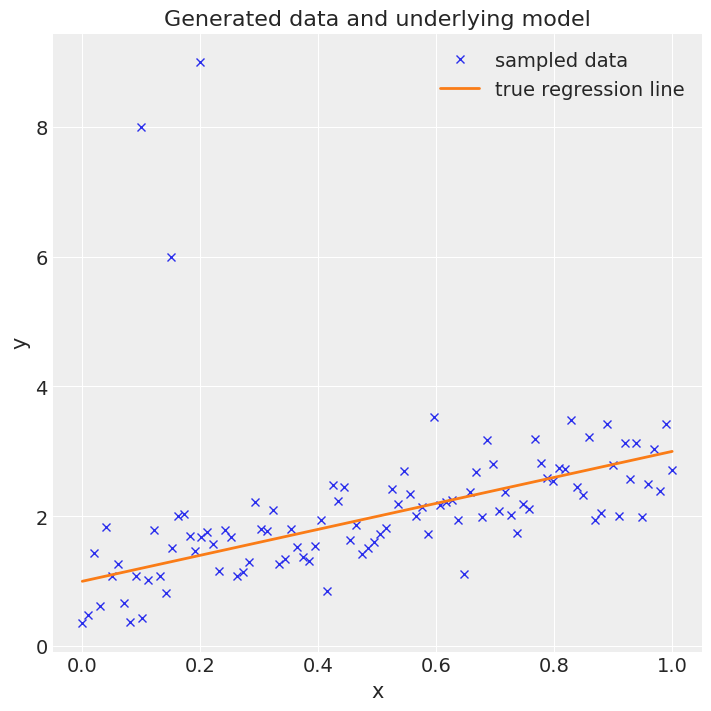

In [18]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

To highlight the problem, first fit a standard normally-distributed linear regression.

In [19]:
# Note, "gaussian" is the default argument for family. Added to be explicit. 
gauss_model = bmb.Model("y ~ x", data, family="gaussian")
gauss_fitted = gauss_model.fit(draws=2000, idata_kwargs={"log_likelihood": True})
gauss_model.predict(gauss_fitted, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [20]:
az.summary(gauss_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.533,0.230,1.093,1.959,0.003,0.002,5481.0,2857.0,1.0
x,1.201,0.400,0.458,1.964,0.005,0.004,5177.0,2869.0,1.0
y_sigma,1.186,0.085,1.032,1.351,0.001,0.001,5873.0,2891.0,1.0
y_mean[0],1.533,0.230,1.093,1.959,0.003,0.002,5481.0,2857.0,1.0
y_mean[1],1.546,0.227,1.113,1.963,0.003,0.002,5487.0,2857.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.722,0.227,2.288,3.143,0.003,0.002,5461.0,3205.0,1.0
y_mean[99],2.734,0.230,2.307,3.176,0.003,0.002,5454.0,3232.0,1.0
y_mean[100],1.653,0.197,1.290,2.027,0.003,0.002,5512.0,3038.0,1.0
y_mean[101],1.714,0.181,1.376,2.048,0.002,0.002,5539.0,3273.0,1.0


Remember, the true intercept was 1, the true slope was 2. The recovered intercept is much higher, and the slope is much lower, so the influence of the outliers is apparent.

Visually, looking at the recovered regression line and posterior predictive HDI highlights the problem further.

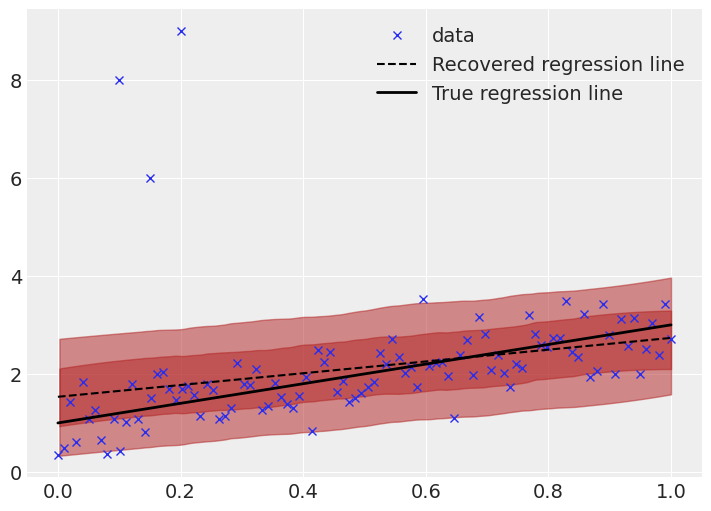

In [21]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = gauss_fitted.posterior.x.mean().item() * x_range + gauss_fitted.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(x_out, gauss_fitted.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="True regression line", lw=2.0, color="black")
plt.legend(loc=0);


The recovered regression line, as well as the $0.5\sigma$ and $1\sigma$ bands are shown. 

Clearly there is skew in the fit. At lower $x$ values, the regression line is far higher than the true line. This is a result of the outliers, which cause the model to assume a higher value in that regime.

Additionally the uncertainty bands are too wide (remember, the $1\sigma$ band ought to cover 68% of the data, while here it covers most of the points). Due to the small probability mass in the tails of a normal distribution, the outliers have an large effect, causing the uncertainty bands to be oversized. 

Clearly, assuming the data are distributed normally is inducing problems here. Bayesian robust linear regression forgoes the normality assumption by instead using a Student T distribution to describe the distribution of the data. The Student T distribution has thicker tails, and by allocating more probability mass to the tails, outliers have a less strong effect.

Comparing the two distributions,

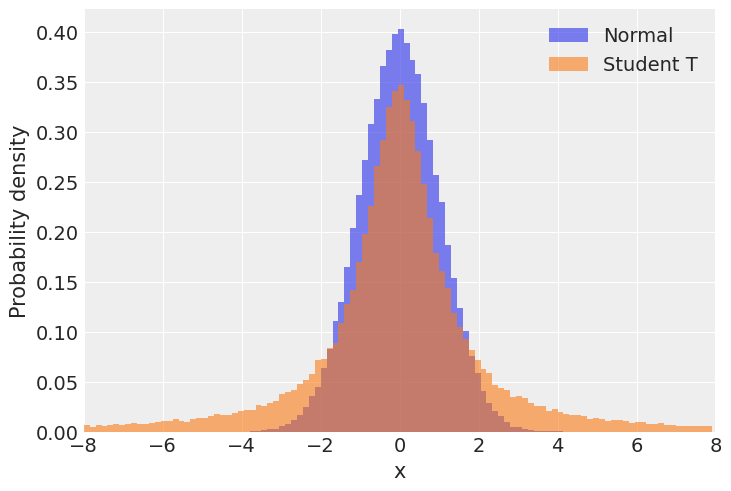

In [22]:
normal_data = np.random.normal(loc=0, scale=1, size=100_000)
t_data = np.random.standard_t(df=1, size=100_000)

bins = np.arange(-8,8,0.15)
plt.hist(normal_data, 
         bins=bins, density=True,
         alpha=0.6,
         label="Normal"
        )
plt.hist(t_data, 
         bins=bins,density=True,
         alpha=0.6,
         label="Student T"
        )
plt.xlabel("x")
plt.ylabel("Probability density")
plt.xlim(-8,8)
plt.legend();

As we can see, the tails of the Student T are much larger, which means values far from the mean are more likely when compared to the normal distribution.

The T distribution is specified by a number of degrees of freedom ($\nu$). In [`numpy.random.standard_t`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_t.html) this is the parameter `df`, in the [pymc T distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.StudentT), it's `nu`. It is constrained to real numbers greater than 0. As the degrees of freedom increase, the probability in the tails Student T distribution decrease. In the limit of $\nu \rightarrow + \infty$, the Student T distribution is a normal distribution. Below, the T distribution is plotted for various $\nu$.

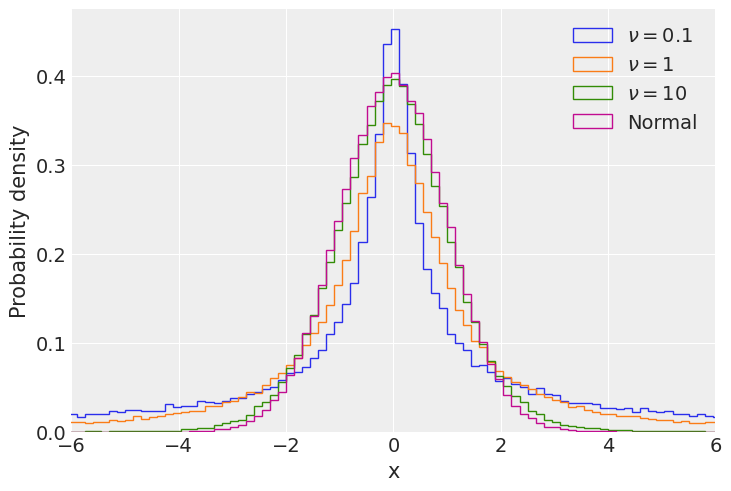

In [23]:
bins = np.arange(-8,8,0.15)
for ndof in [0.1, 1, 10]:

    t_data = np.random.standard_t(df=ndof, size=100_000)

    plt.hist(t_data, 
             bins=bins,density=True,
             label=f"$\\nu = {ndof}$",
             histtype="step"
            )
plt.hist(normal_data, 
         bins=bins, density=True,
         histtype="step",
         label="Normal"
        )    
    
plt.xlabel("x")
plt.ylabel("Probability density")
plt.xlim(-6,6)
plt.legend();

In Bambi, the way to specify a regression with Student T distributed data is by passing `"t"` to the `family` parameter of a Model.

In [24]:
t_model = bmb.Model("y ~ x", data, family="t")
t_fitted = t_model.fit(draws=2000, idata_kwargs={"log_likelihood": True})
t_model.predict(t_fitted, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_sigma, y_nu, Intercept, x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


In [25]:
az.summary(t_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.994,0.107,0.797,1.199,0.002,0.001,4029.0,3029.0,1.0
x,1.900,0.184,1.562,2.254,0.003,0.002,4172.0,3105.0,1.0
y_sigma,0.405,0.046,0.321,0.492,0.001,0.001,4006.0,3248.0,1.0
y_nu,2.601,0.620,1.500,3.727,0.011,0.008,3431.0,3063.0,1.0
y_mean[0],0.994,0.107,0.797,1.199,0.002,0.001,4029.0,3029.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.875,0.103,2.688,3.079,0.001,0.001,4786.0,3228.0,1.0
y_mean[99],2.894,0.105,2.709,3.105,0.002,0.001,4768.0,3155.0,1.0
y_mean[100],1.184,0.091,1.009,1.350,0.001,0.001,4046.0,3140.0,1.0
y_mean[101],1.279,0.084,1.118,1.432,0.001,0.001,4074.0,3151.0,1.0


Note the new parameter in the model, `y_nu`. This is the aforementioned degrees of freedom. If this number were very high, we would expect it to be well described by a normal distribution. However, the HDI of this spans from 1.5 to 3.7, meaning that the tails are much heavier than a normal distribution. As a result of the heavier tails, `y_sigma` has also dropped precipitously from the normal model, meaning the oversized uncertainty bands from above have shrunk.


Comparing the extracted values of the two models,

In [26]:
def get_slope_intercept(mod):
    return (
        mod.posterior.x.mean().item(),
        mod.posterior.Intercept.mean().item()
    )
gauss_slope, gauss_int = get_slope_intercept(gauss_fitted)
t_slope, t_int = get_slope_intercept(t_fitted)

pd.DataFrame({
    "Model":["True","Normal","T"],
    "Slope":[2, gauss_slope, t_slope],
    "Intercept": [1, gauss_int, t_int]
}).set_index("Model").T.round(decimals=2)

Model,True,Normal,T
Slope,2.0,1.20,1.90
Intercept,1.0,1.53,0.99


Here we can see the mean recovered values of both the slope and intercept are far closer to the true values using the robust regression model compared to the normally distributed one.

Visually comparing the robust regression line,

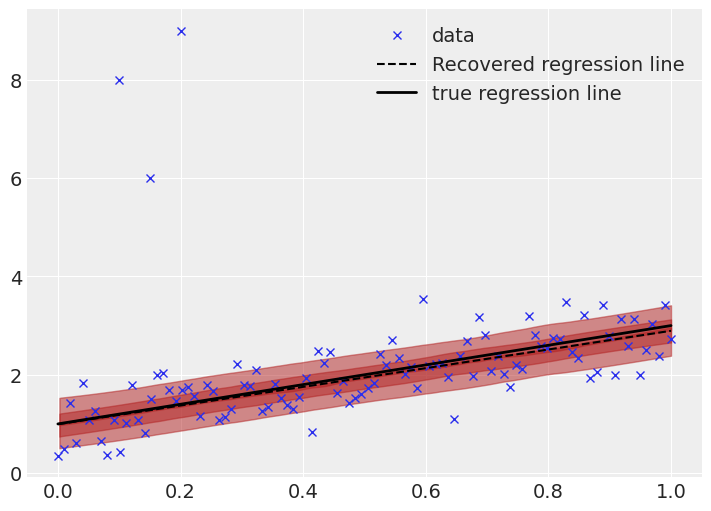

In [27]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered robust linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = t_fitted.posterior.x.mean().item() * x_range + t_fitted.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.05, 0.38, 0.68]:
    az.plot_hdi(x_out, t_fitted.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="true regression line", lw=2.0, color="black")
plt.legend(loc=0);

This is much better. The true and recovered regression lines are much closer, and the uncertainty bands are appropriate sized. The effect of the outliers is not _entirely_ gone, the recovered line still slightly differs from the true line, but the effect is far smaller, which is a result of the Student T likelihood function ascribing a higher probability to outliers than the normal distribution. Additionally, this inference is based on sampling methods, so it is expected to have small differences (especially given a relatively small number of samples).

Last, another way to evaluate the models is to compare based on Leave-one-out Cross-validation (LOO), which provides an estimate of accuracy on out-of-sample predictions.

In [28]:
models = {
    "gaussian": gauss_fitted,
    "Student T": t_fitted
}
df_compare = az.compare(models)
df_compare

/home/tomas/anaconda3/envs/bambi/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T,0,-101.760564,5.603439,0.000000,1.000000e+00,14.994794,0.000000,False,log
gaussian,1,-171.732028,14.081743,69.971464,3.053913e-11,29.382970,17.542539,True,log


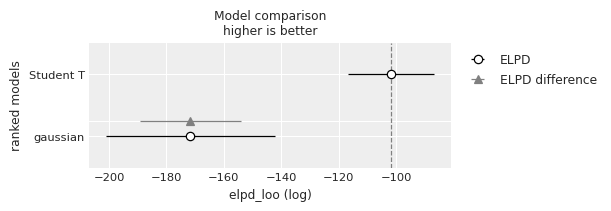

In [29]:
az.plot_compare(df_compare, insample_dev=False);

Here it is quite obvious that the Student T model is much better, due to having a clearly larger value of LOO.

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 05 2023

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.5.0

bambi     : 0.9.3
pandas    : 1.5.2
numpy     : 1.23.5
matplotlib: 3.6.2
sys       : 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
arviz     : 0.14.0

Watermark: 2.3.1

